### Import Libraries

In [6]:
#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import cm
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D #3d Plotting

#Geo-Visualisation
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cluster import MiniBatchKMeans, KMeans

### Helper Functions

In [7]:
# Source: 
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [8]:
#Kann raus oder?
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999 #nicht schön aber sollte funktionieren.
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

In [9]:
# Source: 
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

In [10]:
# Source: self-written
def moving_average(array,n):
    target = []
    rng = n / 2 - 0.5
    rng = int(rng)
    i = 0
    while i < len(array):
        value = 0
        if (i >= rng-1) & (i< len(array)-rng):
            value = sum(array[i-rng:i+rng+1])/n
        target.append(value)
        i = i + 1
    i = 0
    while i < rng:
        target[i] = target[rng]
        target[-i-1] = target[-rng-1]
        i = i + 1
        
    return target

________________________

# Data Cleaning

## Import raw data
We import the given dataset. 

We also import self-gathered data:
- Daily information on whether the day was a national or regional holiday or whether there were school vacations
- Geo-coordinates for city centers of both cities
- SHP files for the cities including city districts

In [11]:
df_b = pd.read_csv("./dataset/bochum.csv")
df_l = pd.read_csv("./dataset/leipzig.csv")

In [12]:
#Self-gathered datasets that gives information about the relevant days
date_info_l = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_l["date"] = pd.to_datetime(date_info_l["date"],format="%d.%m.%Y").dt.date
date_info_l.index = date_info_l["date"]
date_info_l = date_info_l.drop(columns=["date"])

date_info_b = pd.read_csv("./resources/date-info/leipzig-dateinfo.csv",sep=";")
date_info_b["date"] = pd.to_datetime(date_info_b["date"],format="%d.%m.%Y").dt.date
date_info_b.index = date_info_b["date"]
date_info_b = date_info_b.drop(columns=["date"])

In [13]:
leipzig = {"lng": 12.3741468,"lat": 51.340744}
bochum = {"lng": 7.2164417,"lat": 51.4816637}

In [14]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system
bochum_map = gpd.read_file("./resources/bochum/Stadtbezirke.shp").to_crs(epsg=4326).rename(columns={"Stadtbezir":"Name"})

### Looking for null values
We look for holes in the data. Note that, as data event-based and not continuous, we do not discover missing "events" (e.g. if there are no records for certain days).

In [15]:
print("Total number of null values:",
      (sum(df_l.isnull().sum())+sum(df_l.isnull().sum())))

Total number of null values: 0


### Correcting Data Types

In [16]:
def correct_data_types(Nextbike):
    #Converting Trip Length to timedelta
    Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

    #Converting start-time to datetime
    Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
    Nextbike.drop(columns=['day','time'], inplace = True)

    #round coordinates to filter out gps unpreciseness
    cols = ["orig_lat","orig_lng","dest_lat","dest_lng"]
    Nextbike[cols] = Nextbike[cols].round(3)
    
    return Nextbike

df_l = correct_data_types(df_l)
df_b = correct_data_types(df_b)

### Add columns for analysis
We then proceed to calculate some useful columns that will help us analyse the dataset. While this might produce some columns that are not frequently used, we benefit from having all beneficial information ready for use.

To attempt to approximate the resulting revenue, we stick to the only pricing strategy that can be applied to the data that we have, which is 1€ per 30 minutes. Note that Nextbike offers a lot of different pricing strategies, including flat rates and free minutes for students. We do not have enough information to include these in our calculation - so the Revenue metric is very likely to be misrepresentative and has to be taken with a grain of salt.

In [17]:
def add_columns_analysis(Nextbike,date_info):
    Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

    Nextbike["date"] = Nextbike.timestamp.dt.date
    Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
    Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week
    
    Nextbike["trip_duration_minutes"] = Nextbike["trip_duration"].dt.total_seconds()/60

    Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
    Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

    Nextbike['Time_float'] = Nextbike['timestamp'].dt.time
    Nextbike['Time_float'] = Nextbike['Time_float'].astype(str).str[3:5].astype(float)/60 + Nextbike["Time"]
    
    #take trip duration in minutes, calculate 1€ per 30 minutes of usage
    Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)
      
        
    Nextbike=pd.merge(Nextbike,date_info,left_on="date",right_index=True)
    Nextbike["free"] = ((Nextbike["day_classifier"]=="weekend") | (Nextbike["holiday"]=="1"))
    
    return Nextbike


df_l = add_columns_analysis(df_l,date_info_l)
df_b = add_columns_analysis(df_b,date_info_b)

In [18]:
def calc_traveled_distance(df):
    distances = []
    for index, row in df.iterrows():
        distances.append(calculate_distance(row["orig_lng"], 
                                            row["orig_lat"],
                                            row["dest_lng"], 
                                            row["dest_lat"]))
    return distances

df_l["distance_traveled"]=calc_traveled_distance(df_l)
df_b["distance_traveled"] = calc_traveled_distance(df_b)
df_l

b_number     city   trip_duration  orig_lat  orig_lng  dest_lat  \
0          10900  leipzig 0 days 00:12:00    51.330    12.342    51.330   
1          10900  leipzig 0 days 00:08:00    51.330    12.342    51.330   
2          10900  leipzig 0 days 00:40:00    51.330    12.342    51.330   
3          10900  leipzig 0 days 00:03:00    51.330    12.342    51.330   
2788       20204  leipzig 0 days 00:13:00    51.333    12.404    51.339   
...          ...      ...             ...       ...       ...       ...   
171614     39065  leipzig 0 days 00:38:00    51.326    12.375    51.331   
171615     39065  leipzig 0 days 00:10:00    51.331    12.374    51.335   
171616     39065  leipzig 0 days 00:07:00    51.335    12.391    51.332   
171617     39065  leipzig 0 days 00:09:00    51.331    12.406    51.319   
171618     39065  leipzig 0 days 00:10:00    51.319    12.401    51.333   

        dest_lng           timestamp   timestamp_rounded        date  ...  \
0         12.342 2019-04-16 11:17:00 2019-04-16 11:00:00  2019-04-16  ...   
1         12.342 2019-04-16 11:35:00 2019-04-16 11:00:00  2019-04-16  ...   
2         12.342 2019-04-16 11:53:00 2019-04-16 11:00:00  2019-04-16  ...   
3         12.342 2019-04-16 14:35:00 2019-04-16 14:00:00  2019-04-16  ...   
2788      12.382 2019-04-16 05:52:00 2019-04-16 05:00:00  2019-04-16  ...   
...          ...                 ...                 ...         ...  ...   
171614    12.374 2019-03-27 15:06:00 2019-03-27 15:00:00  2019-03-27  ...   
171615    12.391 2019-03-27 16:28:00 2019-03-27 16:00:00  2019-03-27  ...   
171616    12.406 2019-03-27 17:09:00 2019-03-27 17:00:00  2019-03-27  ...   
171617    12.401 2019-03-27 18:00:00 2019-03-27 18:00:00  2019-03-27  ...   
171618    12.412 2019-03-27 20:59:00 2019-03-27 20:00:00  2019-03-27  ...   

        week  trip_duration_minutes  Time  Time_float  revenue  \
0         16                   12.0    11   11.283333      1.0   
1         16                    8.0    11   11.583333      1.0   
2         16                   40.0    11   11.883333      2.0   
3         16                    3.0    14   14.583333      1.0   
2788      16                   13.0     5    5.866667      1.0   
...      ...                    ...   ...         ...      ...   
171614    13                   38.0    15   15.100000      2.0   
171615    13                   10.0    16   16.466667      1.0   
171616    13                    7.0    17   17.150000      1.0   
171617    13                    9.0    18   18.000000      1.0   
171618    13                   10.0    20   20.983333      1.0   

        day_classifier vacations  holiday   free  distance_traveled  
0              weekday         0        0  False           0.000000  
1              weekday         0        0  False           0.000000  
2              weekday         0        0  False           0.000000  
3              weekday         0        0  False           0.000000  
2788           weekday         0        0  False           1.667600  
...                ...       ...      ...    ...                ...  
171614         weekday         0        0  False           0.560299  
171615         weekday         0        0  False           1.262030  
171616         weekday         0        0  False           1.094186  
171617         weekday         0        0  False           1.378829  
171618         weekday         0        0  False           1.734244  

[185327 rows x 21 columns]

### Creating an array with all dates
This is a simple array that contains all dates from the range of our data. It will help us in our analysis on some occasions.

In [19]:
start_date = df_l.date.min()
end_date = df_l.date.max()
delta = pd.to_timedelta("1d")
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
    
dates_df = pd.DataFrame(index=dates)

## Cleaning up unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area. We start by calculating the distances to the city centre for origin and destination. We then filter out rides that are way outside of the distribution of distance.

Text(0.5, 1.0, 'Bochum')

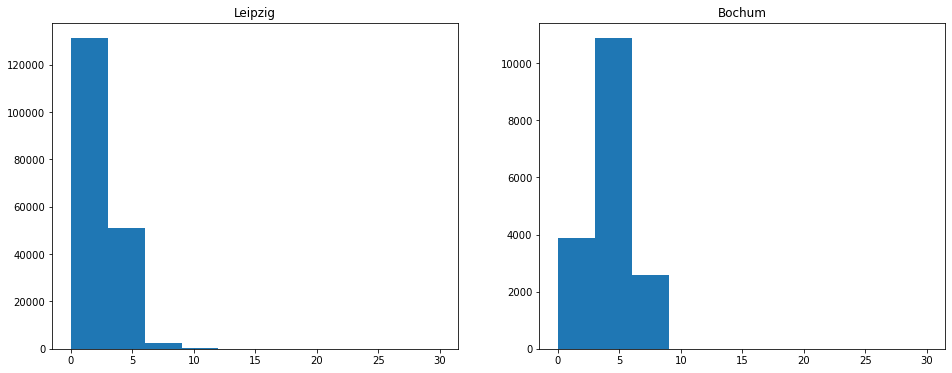

In [20]:
def add_distances_center(df,city):
    start_distance_center = []
    end_distance_center = []
    max_distance_center = []

    for index, row in df.iterrows():
        start = calculate_distance(lon1 = row["orig_lng"],
                               lat1 = row["orig_lat"],
                               lon2 = city["lng"],
                               lat2 = city["lat"])
        end = calculate_distance(lon1 = row["dest_lng"], 
                                lat1 = row["dest_lat"],
                                lon2 = city["lng"],
                                lat2 = city["lat"])
        if start > end:
            max = start
        else:
            max = end
        start_distance_center.append(start)
        end_distance_center.append(end)
        max_distance_center.append(max)

    df["start_distance_center"] = start_distance_center
    df["end_distance_center"] = end_distance_center
    df["max_distance_center"] = max_distance_center

    #df["max_distance_center"] = df["max_distance_center"].round()

    distances = df.groupby("max_distance_center").agg(
    count = ("b_number","count"))

    
add_distances_center(df_l,leipzig)
add_distances_center(df_b,bochum)

# Output
Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_l["max_distance_center"]
axes[0].hist(x,range=(0,30))
axes[0].set_title('Leipzig')

x = df_b["max_distance_center"]
axes[1].hist(x,range=(0,30))
axes[1].set_title('Bochum')

In [21]:
df_l = df_l[df_l["max_distance_center"]<=15]
df_b = df_b[df_b["max_distance_center"]<=10]

## Find out size of the fleet
As in our opinion, the total number of available bikes is a vital part for KPIs (e.g. amount of rides per available bikes), but also a relevant feature for predicting bike demand (we suspect more available bikes per km2 --> more attractive to rent a bike), we feel it is vital to know how the size of the fleet in the respective city changes over time.

Unfortunately, this data is not available in our dataset and thus has to be approximated through logics.

Our idea is to first get a feel about how much time (maximally) lies between rides with one specific bike. If we, for example, know that bikes never go over 7 days of not being used, we can count the number of unique bike IDs that were ridden at least once in the last 7 days to approximate the fleet size for a given date.

Text(0.5, 1.0, 'Bochum')

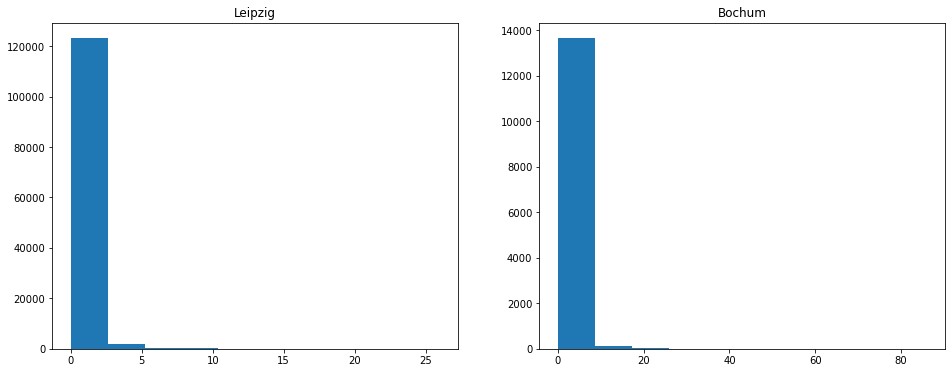

In [22]:
def stood_time(df):
    
    dfx = df.copy()[["b_number","timestamp","trip_duration","orig_lat","orig_lng","dest_lat","dest_lng"]]
    dfx["timestamp_end"] = dfx["timestamp"] + dfx["trip_duration"]
    
    events = []
    
    for number in dfx["b_number"].unique():
        dfi = dfx[dfx["b_number"]==number].sort_values(by="timestamp")
        i = 0
        for index,row in dfi.iterrows():
            i = i + 1
            if i > 1:
                status = "moved"
                if [row["orig_lat"],row["orig_lng"]] == last_dest:
                    status = "stood"

                d = {
                    "b_number": number,
                    "from": last_timestamp,
                    "to": row["timestamp"],
                    "status": status
                }
                events.append(d)
            last_timestamp = row["timestamp_end"]
            last_dest = [row["dest_lat"],row["dest_lng"]]

    events = pd.DataFrame(events)
    events["length"] = events["to"] - events["from"]
    events["length_days"] = events["length"].dt.total_seconds() / (60* 60* 24)
    events["length_days"] = events["length_days"].round()
    
    return events[events["status"]=="stood"]
    

stood_l = stood_time(df_l)
stood_b = stood_time(df_b)

# Output
Fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = stood_l["length_days"]
axes[0].hist(x)
axes[0].set_title('Leipzig')

x = stood_b["length_days"]
axes[1].hist(x)
axes[1].set_title('Bochum')

We see that for Leipzig, most time deltas between rides seem to be from 0 to 3 days, with some ranging up to 10. Bochum shows a similar distribution, although there is a visible amount up to arount 20. We choose our calculation parameter accordingly.

Note that this is a balancing act: If we choose this number to high, we will include bikes that are not really in use anymore. If we choose it too small, we might not include bikes that are still active but were simply not used for a longer amount of time.

In [23]:
def fleet_size(df,factor):
    
    fleet_size = pd.DataFrame([], index = dates, columns = ["fleet_size"]) 

    search_array = []
    values = []
    for index, row in fleet_size.iterrows():
        search_array.append(index)
        if len(search_array) > factor:
            search_array.pop(0)
        values.append(df[df["date"].isin(search_array[:])].b_number.nunique())
        
    i = 0
    
    #Erklärung hierfür
    correction = values[factor-1]
    while i < factor-1:
        values[i] = correction
        i = i + 1
    fleet_size["fleet_size"] = values
    
    return fleet_size

fleet_size_l = fleet_size(df_l,10)
fleet_size_b = fleet_size(df_b,20)

## Creating per-day DataFrame

In [24]:
def df_by_date(df,fleet_size):
    df_by_date = df.groupby("date").agg(
        week = ("week","min"),
        weekday = ("weekday","min"),
        daily_revenue=('revenue', "sum"),
        daily_trips=("b_number","count"),
        free = ("free","min"),
        daily_avg_length = ("trip_duration_minutes","mean"),
        daily_used_bikes=('b_number', pd.Series.nunique))

    df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
    df_by_date_merged["daily_usage"] = df_by_date_merged["daily_used_bikes"] / df_by_date_merged["fleet_size"]

    
    return df_by_date_merged


df_date_l = df_by_date(df_l,fleet_size_l)
df_date_b = df_by_date(df_b,fleet_size_b)

In [25]:
def add_trips_week(df):
    df_week = df.groupby("week").agg(weekly_trips=("daily_trips","sum"))
    return pd.merge(df,df_week,left_on="week",right_index=True,how="left")

In [26]:
df_date_l = add_trips_week(df_date_l)
df_date_l["weekly_relative_trips"] = df_date_l["daily_trips"] / df_date_l["weekly_trips"]
df_date_b = add_trips_week(df_date_b)
df_date_b["weekly_relative_trips"] = df_date_b["daily_trips"] / df_date_b["weekly_trips"]

## Creating per-hour DataFrame
This DataFrame is the core of the project as most of the analyses rely on hourly data. It contains all useful hour-level data, and it contains all day-level data such as fleet size, day classifiers etc.

In [27]:
def df_by_hour(df,df_date):

    df_by_hour = df.groupby("timestamp_rounded").agg(
        revenue=('revenue', "sum"),
        trips=("b_number","count"),
        date=("date","min"),
        time = ("Time","min"),
        avg_length = ("trip_duration_minutes","mean"),
        weekday=("weekday","min"),
        used_bikes=('b_number', pd.Series.nunique))


    df_by_hour_merged = pd.merge(df_by_hour, df_date, right_index=True, left_on='date')


    df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
    df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]
    
    return df_by_hour_merged


df_hour_l = df_by_hour(df_l, df_date_l)
df_hour_b = df_by_hour(df_b, df_date_b)

___________________________________

## KPIs

Our dataset has missing data on three days, in both cities. While this does not have any effect on clustering and regression operations, it does leave a hole when plotting daily KPIs and rental patterns (when dates are on the x axis). Thus we have to fill these holes for these analyses. 

In [66]:
from datetime import datetime, timedelta
df_kpi_l = df_date_l.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]
df_kpi_b = df_date_b.copy()[["fleet_size","daily_trips","daily_revenue","daily_avg_length"]]

def add_missing_days(df_kpi,dates,days):
    newdf = df_kpi.copy()
    df_missingdays = pd.merge(dates,df_kpi,left_index=True,right_index=True,how="left").isnull()
    df_missingdays = df_missingdays[df_missingdays["fleet_size"]==True]
    
    for day in df_missingdays.index:
        copyrow = df_kpi[df_kpi.index == (day + timedelta(days=days))]
        copyrow.index = copyrow.index - timedelta(days=days)
        newdf=newdf.append(copyrow)
    newdf=newdf.sort_index()
    return newdf

df_kpi_l= add_missing_days(df_kpi_l,dates_df,-7)
df_kpi_b= add_missing_days(df_kpi_b,dates_df,-7)

We then proceed to add our KPIs to our DataFrames. We also apply a moving average conversion to smooth out our data. We do this for better visibility of trends and differences between the respective cities.

In [67]:
def add_kpis(df_kpi):
    df_kpi["trips_per_bike"] = df_kpi["daily_trips"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_bike"] = df_kpi["daily_revenue"]/df_kpi["fleet_size"]
    df_kpi["revenue_per_trip"] = df_kpi["daily_revenue"]/df_kpi["daily_trips"]

    
    df_kpi["trips_per_bike_ma"] = moving_average(df_kpi["trips_per_bike"],7)
    df_kpi["revenue_per_bike_ma"] = moving_average(df_kpi["revenue_per_bike"],7)
    df_kpi["revenue_per_trip_ma"] = moving_average(df_kpi["revenue_per_trip"],7)
    
    df_kpi["daily_trips_ma"] =  moving_average(df_kpi["daily_trips"],7)
    df_kpi["daily_avg_length_ma"] = moving_average(df_kpi["daily_avg_length"],7)


add_kpis(df_kpi_l)
add_kpis(df_kpi_b)

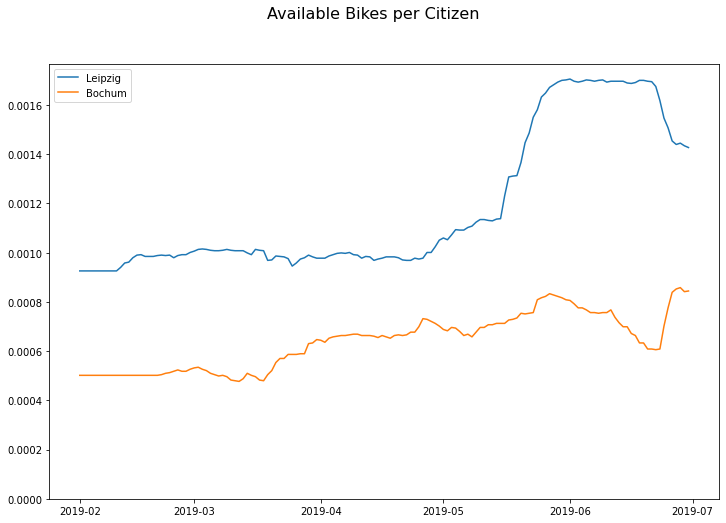

In [94]:
fig,axis = plt.subplots(1,1,figsize=(12,8))

_=axis.plot(df_kpi_l.index,(df_kpi_l["fleet_size"]/560472),label = "Leipzig") #Einwohner Leipzig
_=axis.plot(df_kpi_b.index,(df_kpi_b["fleet_size"]/364742),label = "Bochum") #Einwohner Bochum

axis.set_ylim(bottom=0)
axis.legend()
_=fig.suptitle("Available Bikes per Citizen", fontsize=16)

plt.savefig('./Exports/KPIs/Bikes_per_citizen.png', bbox_inches='tight')

In [69]:
def plot_kpis(df_kpi_l,df_kpi_b,kpi_name,title):
    fig,axis = plt.subplots(1,1,figsize=(12,8))
    axis.plot(df_kpi_l.index, df_kpi_l[kpi_name],label="Leipzig")
    axis.plot(df_kpi_b.index,df_kpi_b[kpi_name],label="Bochum")
    axis.set_ylim(bottom=0)
    axis.legend()
    fig.suptitle(title, fontsize=16)

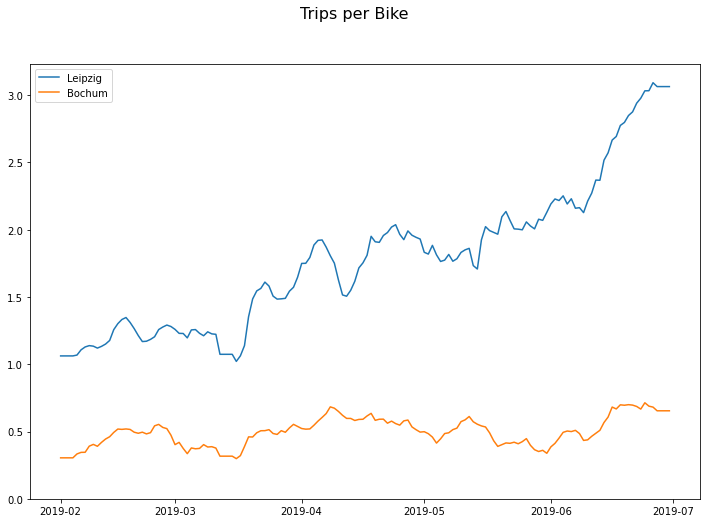

In [95]:
plot_kpis(df_kpi_l,df_kpi_b,"trips_per_bike_ma","Trips per Bike")
plt.savefig('./Exports/KPIs/Trips_per_bike.png', bbox_inches='tight')

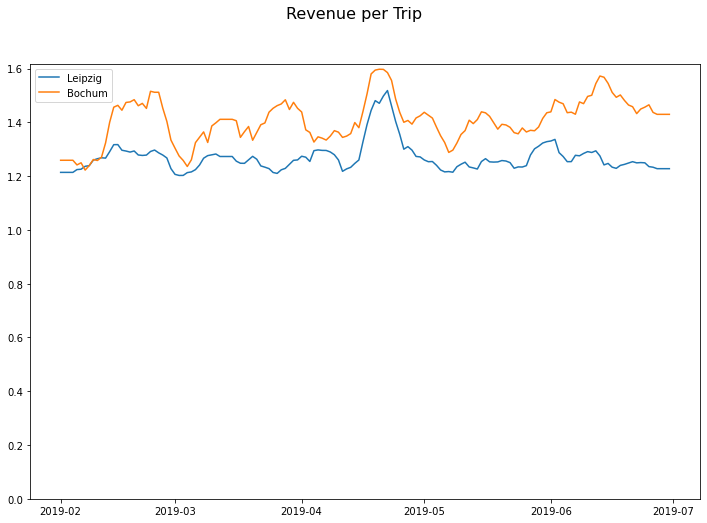

In [96]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_trip_ma","Revenue per Trip")
plt.savefig('./Exports/KPIs/Revenue_per_trip.png', bbox_inches='tight')

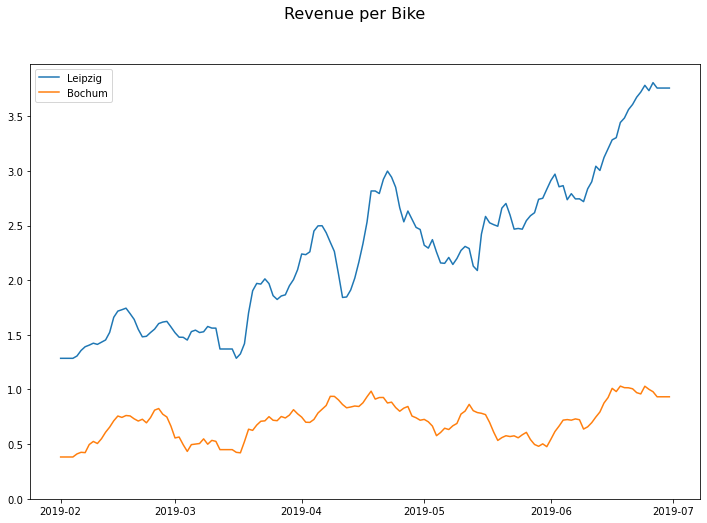

In [97]:
plot_kpis(df_kpi_l,df_kpi_b,"revenue_per_bike_ma","Revenue per Bike")
plt.savefig('./Exports/KPIs/Revenue_per_bike.png', bbox_inches='tight')

_______________________________

## Rental Patterns

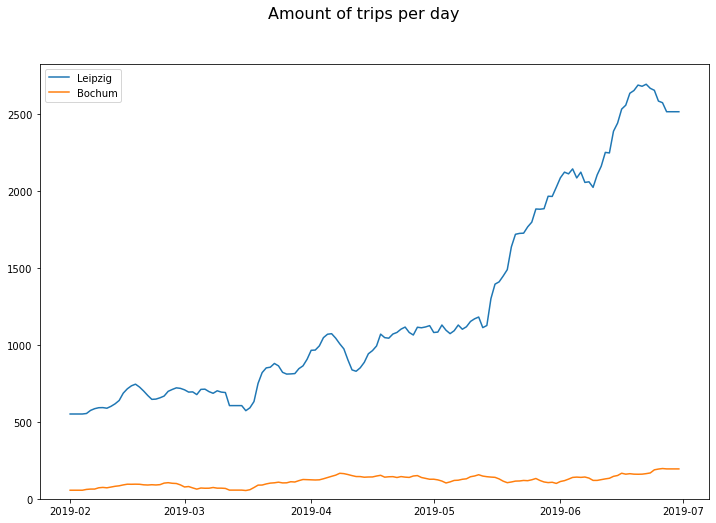

In [99]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_trips_ma","Amount of trips per day")
plt.savefig('./Exports/Rental-Patterns/trips_total.png', bbox_inches='tight')

### Weekly Trip distribution

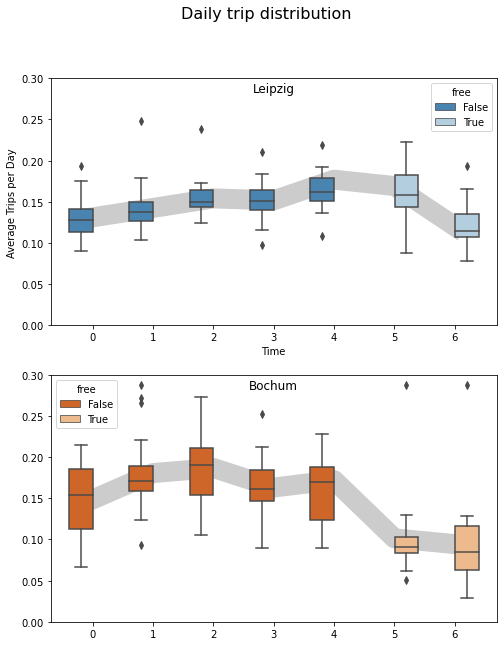

In [100]:
weekly_trend_l = df_date_l[["weekday","free","weekly_relative_trips"]]
weekly_trend_b = df_date_b[["weekday","free","weekly_relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="weekly_relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("weekly_relative_trips","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.3))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trips per Day')
axes[0].set_xlabel('Time')

plt.savefig('./Exports/Rental-Patterns/trips_weekly.png', bbox_inches='tight')

### Hourly Trip distribution

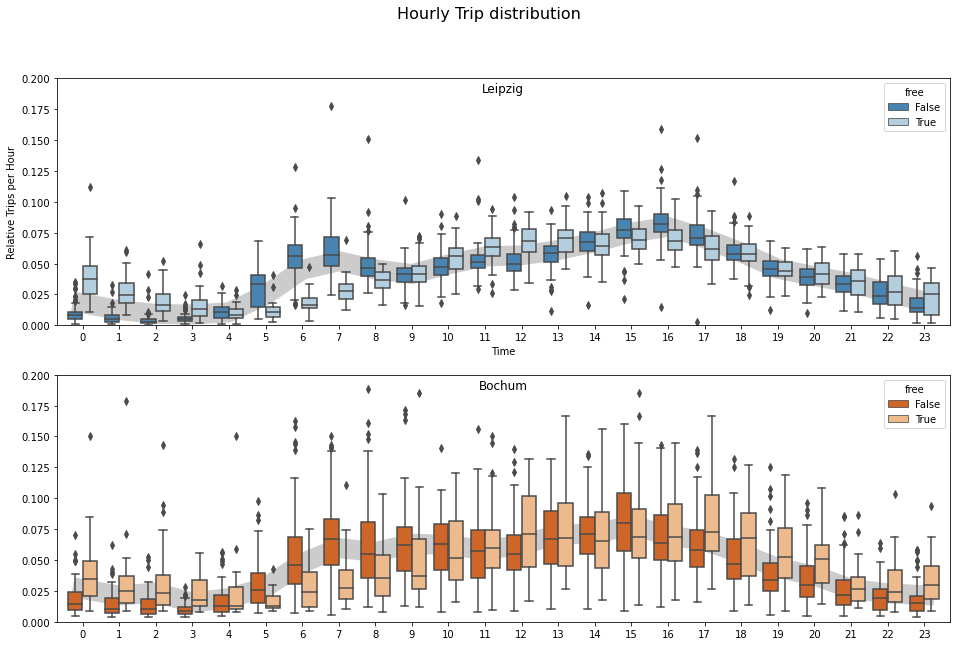

In [101]:
daily_trend_l = df_hour_l[["time","free","relative_trips"]]
daily_trend_b = df_hour_b[["time","free","relative_trips"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Hourly Trip distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="relative_trips", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("relative_trips","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 0.2))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Relative Trips per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/trips_daily.png', bbox_inches='tight')

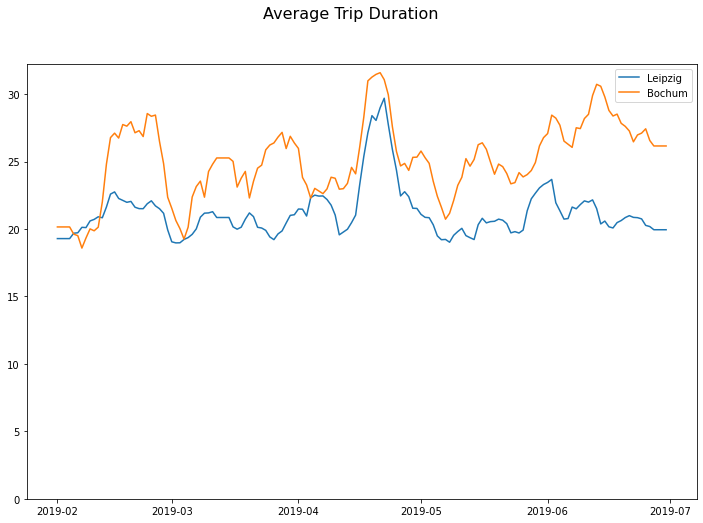

In [104]:
plot_kpis(df_kpi_l,df_kpi_b,"daily_avg_length_ma","Average Trip Duration")


plt.savefig('./Exports/Rental-Patterns/duration_total.png', bbox_inches='tight')

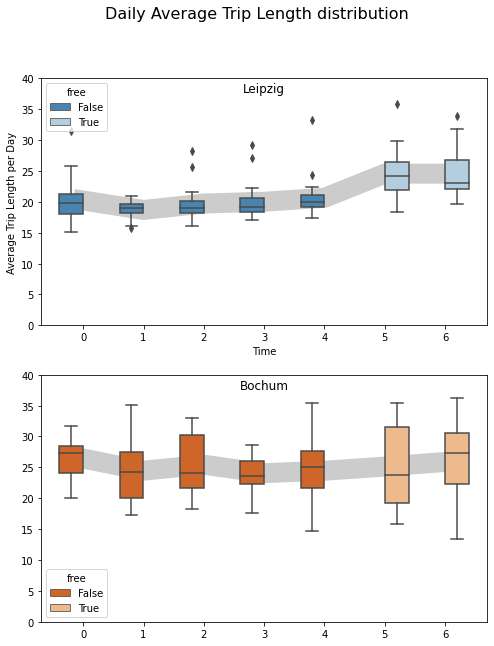

In [105]:
weekly_trend_l = df_date_l[["weekday","free","daily_avg_length"]]
weekly_trend_b = df_date_b[["weekday","free","daily_avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(8, 10))
Fig_1.suptitle('Daily Average Trip Length distribution', fontsize=16)

color_palette = "Blues_r"
i = 0
weekly_trends = [weekly_trend_l,weekly_trend_b]
for weekly_trend in weekly_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=weekly_trend, 
                     x="weekday", 
                     y="daily_avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    weekly_trend_avg = weekly_trend.groupby("weekday").agg(relative_trips = ("daily_avg_length","mean"))
    avg = axes[i].plot(weekly_trend_avg.index,
                       weekly_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 40))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Day')
axes[0].set_xlabel('Time')

plt.savefig('./Exports/Rental-Patterns/duration_weekly.png', bbox_inches='tight')

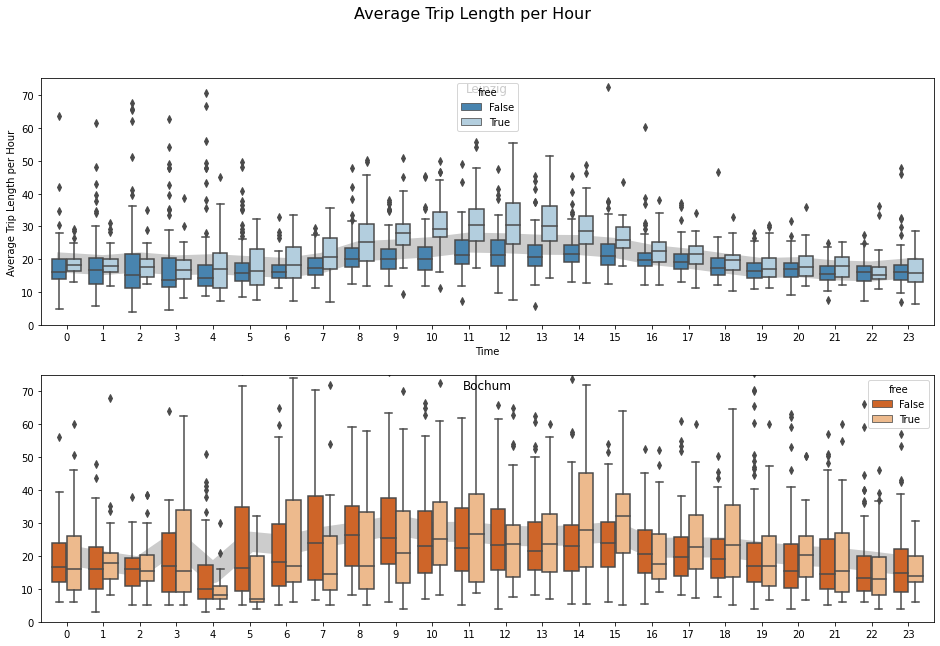

In [106]:
daily_trend_l = df_hour_l[["time","free","avg_length"]]
daily_trend_b = df_hour_b[["time","free","avg_length"]]


Fig_1,axes = plt.subplots(2, 1, figsize=(16, 10))
Fig_1.suptitle('Average Trip Length per Hour', fontsize=16)

color_palette = "Blues_r"
i = 0
daily_trends = [daily_trend_l,daily_trend_b]
for daily_trend in daily_trends:
    if i>0:
        color_palette = "Oranges_r"
    boxplot = sns.boxplot(ax = axes[i],
                     data=daily_trend, 
                     x="time", 
                     y="avg_length", 
                     hue='free', 
                     palette=color_palette,
                     zorder = 1)
    
    daily_trend_avg = daily_trend.groupby("time").agg(relative_trips = ("avg_length","mean"))
    avg = axes[i].plot(daily_trend_avg.index,
                       daily_trend_avg.relative_trips,
                       zorder = 0,
                       color="black",
                       linewidth=20,
                       alpha = 0.2)
    
    axes[i].set(ylim=(0, 75))
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')#Prevent Labels, only show it on the first
    i = i + 1
    
axes[0].set_title("Leipzig",y=1.0, pad=-14)
axes[1].set_title("Bochum",y=1.0, pad=-14)
axes[0].set_ylabel('Average Trip Length per Hour')
axes[0].set_xlabel('Time')
#axes[1].legend().remove()

plt.savefig('./Exports/Rental-Patterns/duration_daily.png', bbox_inches='tight')

## Geographic Rental Patterns
In this step, we plot the distribution of start and end locations of bike rentals in respect to the area. We focus on working days, as we expect less diffuse use of bikes (based on impressions from e.g. the hourly trip distribution)

In [108]:
def area_array(df,polys,lng,lat):
    
    gdf = gpd.GeoDataFrame(df[[lng,lat]], geometry=gpd.points_from_xy(df[lng], df[lat]))
    
    stadtteile = []

    for index,row in gdf.iterrows():
        point = row["geometry"]
        stadtteil = None
        
        for indox,rew in polys.iterrows():
            if point.within(rew["geometry"]):
                stadtteil = rew["Name"]
                break
                
        stadtteile.append(stadtteil)
       
    return stadtteile

In [109]:
df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")
df_b["start_area"] = area_array(df_b,bochum_map,"orig_lng","orig_lat")
df_b["end_area"] = area_array(df_b,bochum_map,"dest_lng","dest_lat")

<ipython-input-109-67c0c91518ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l["start_area"] = area_array(df_l,leipzig_map,"orig_lng","orig_lat")
<ipython-input-109-67c0c91518ed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l["end_area"] = area_array(df_l,leipzig_map,"dest_lng","dest_lat")


In [112]:
def plot_sliced_days(df,polys,slices,titlecity):
    slice_size = 24/slices
    fig, axes = plt.subplots(2, slices, figsize=(30,20))
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    i=0
    while i < slices:
        min_time = slice_size*i
        max_time = min_time + slice_size - 1
        dfx = df[(df["Time"]>=min_time)&(df["Time"]<=max_time)]  # filter out only weekdays

        plottable_start = dfx.groupby("start_area").agg(count = ("start_area","count"))
        plottable_start = pd.merge(polys, plottable_start, left_on="Name", right_index=True)
        
        plottable_end = dfx.groupby("end_area").agg(count = ("end_area","count"))
        plottable_end = pd.merge(polys, plottable_end, left_on="Name", right_index=True)
            
        plottable_start.plot(ax=axes[0,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[0,i],crs=4326)
        polys.plot(ax=axes[0,i],zorder=3,alpha=0)
        axes[0,i].set_title('Start, '+str(min_time)+"h to " + str(max_time) + "h")
        
        plottable_end.plot(ax=axes[1,i], alpha=0.8, edgecolor='darkgrey',cmap="Blues",column='count', zorder=1,  legend=False)
        ctx.add_basemap(ax=axes[1,i],crs=4326)
        polys.plot(ax=axes[1,i],zorder=3,alpha=0)
        axes[1,i].set_title('End, '+str(min_time)+"h to " + str(max_time) + "h")
        i = i + 1
    
    ylim1,ylim2 = axes[0,0].get_ylim()
    xlim1,xlim2 = axes[0,0].get_xlim()

    for axis in axes[0]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)
    for axis in axes[1]:
        axis.set_ylim(ylim1,ylim2)
        axis.set_xlim(xlim1,xlim2)

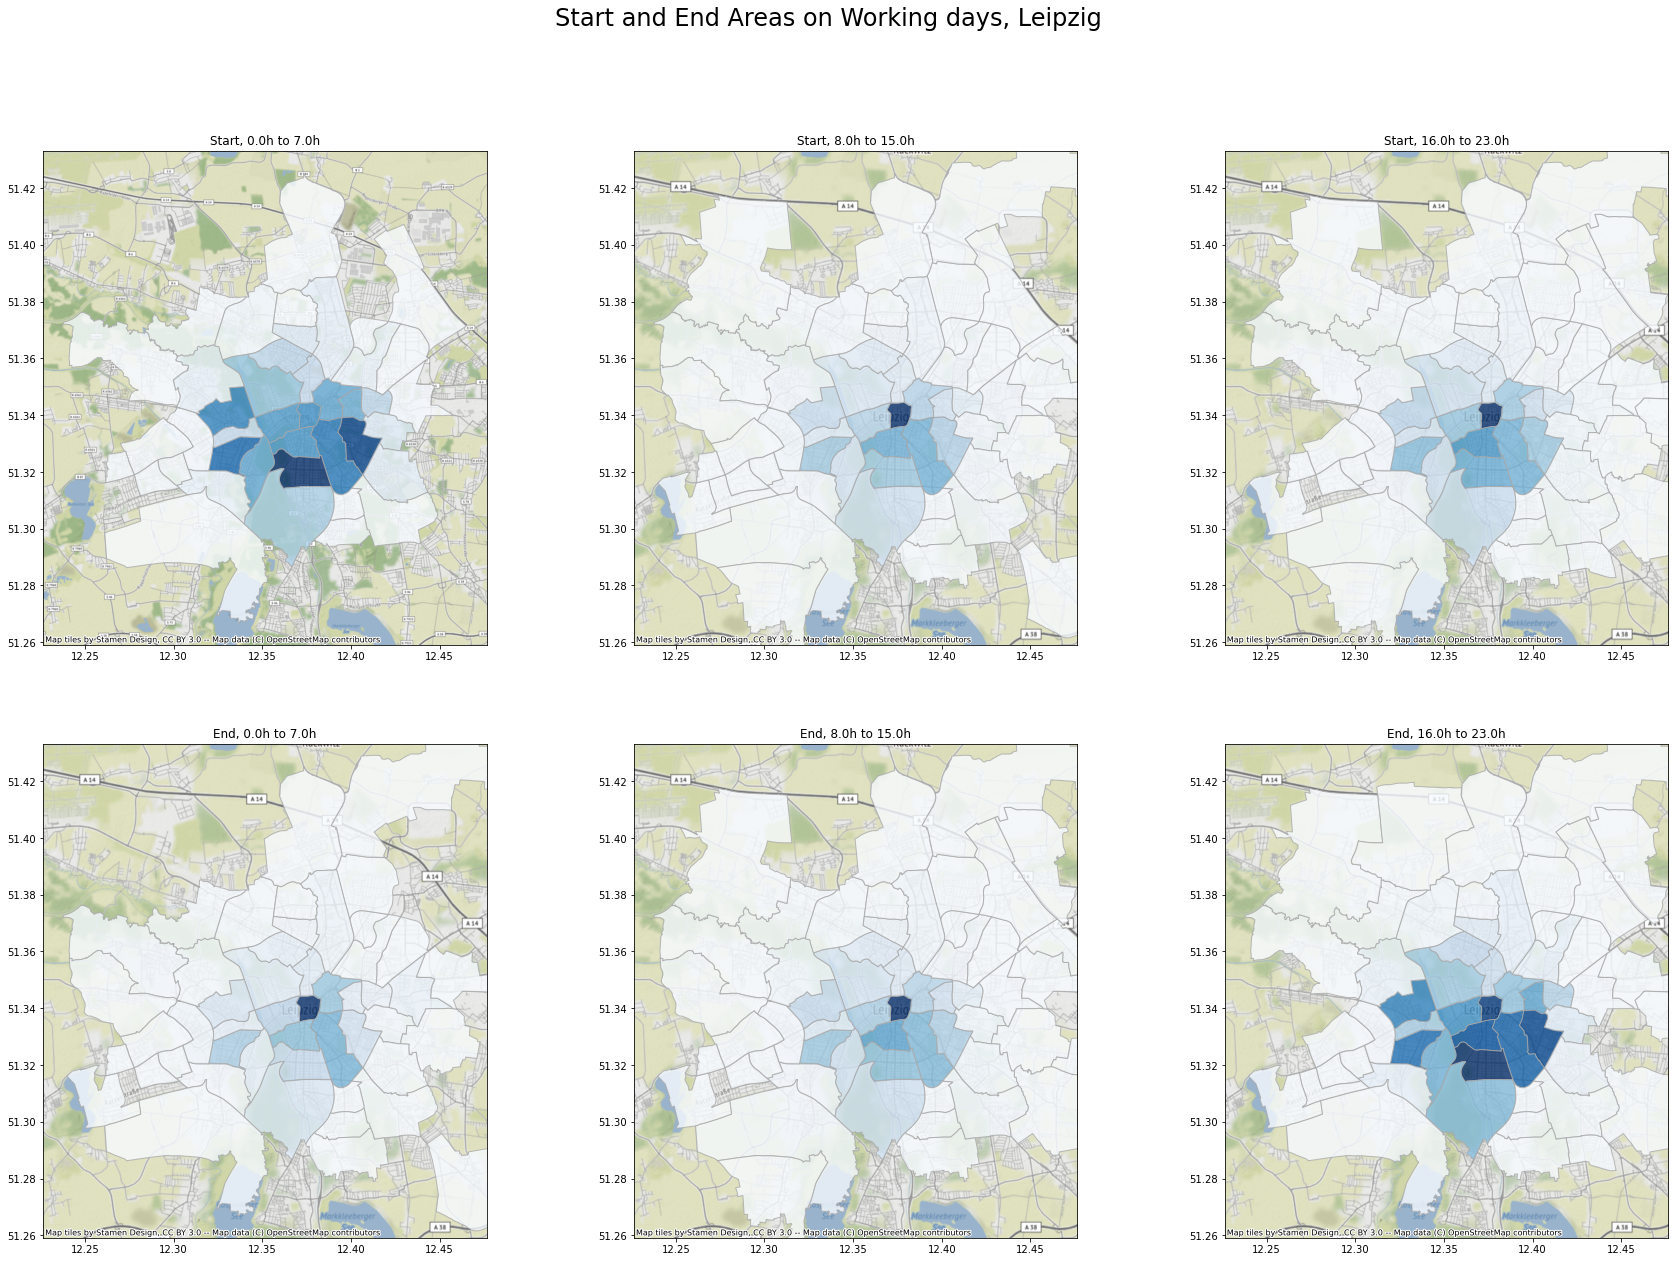

In [113]:
plot_sliced_days(df=df_l[df_l["free"]==False],polys=leipzig_map,slices=3,titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_areas_leipzig.png', bbox_inches='tight')


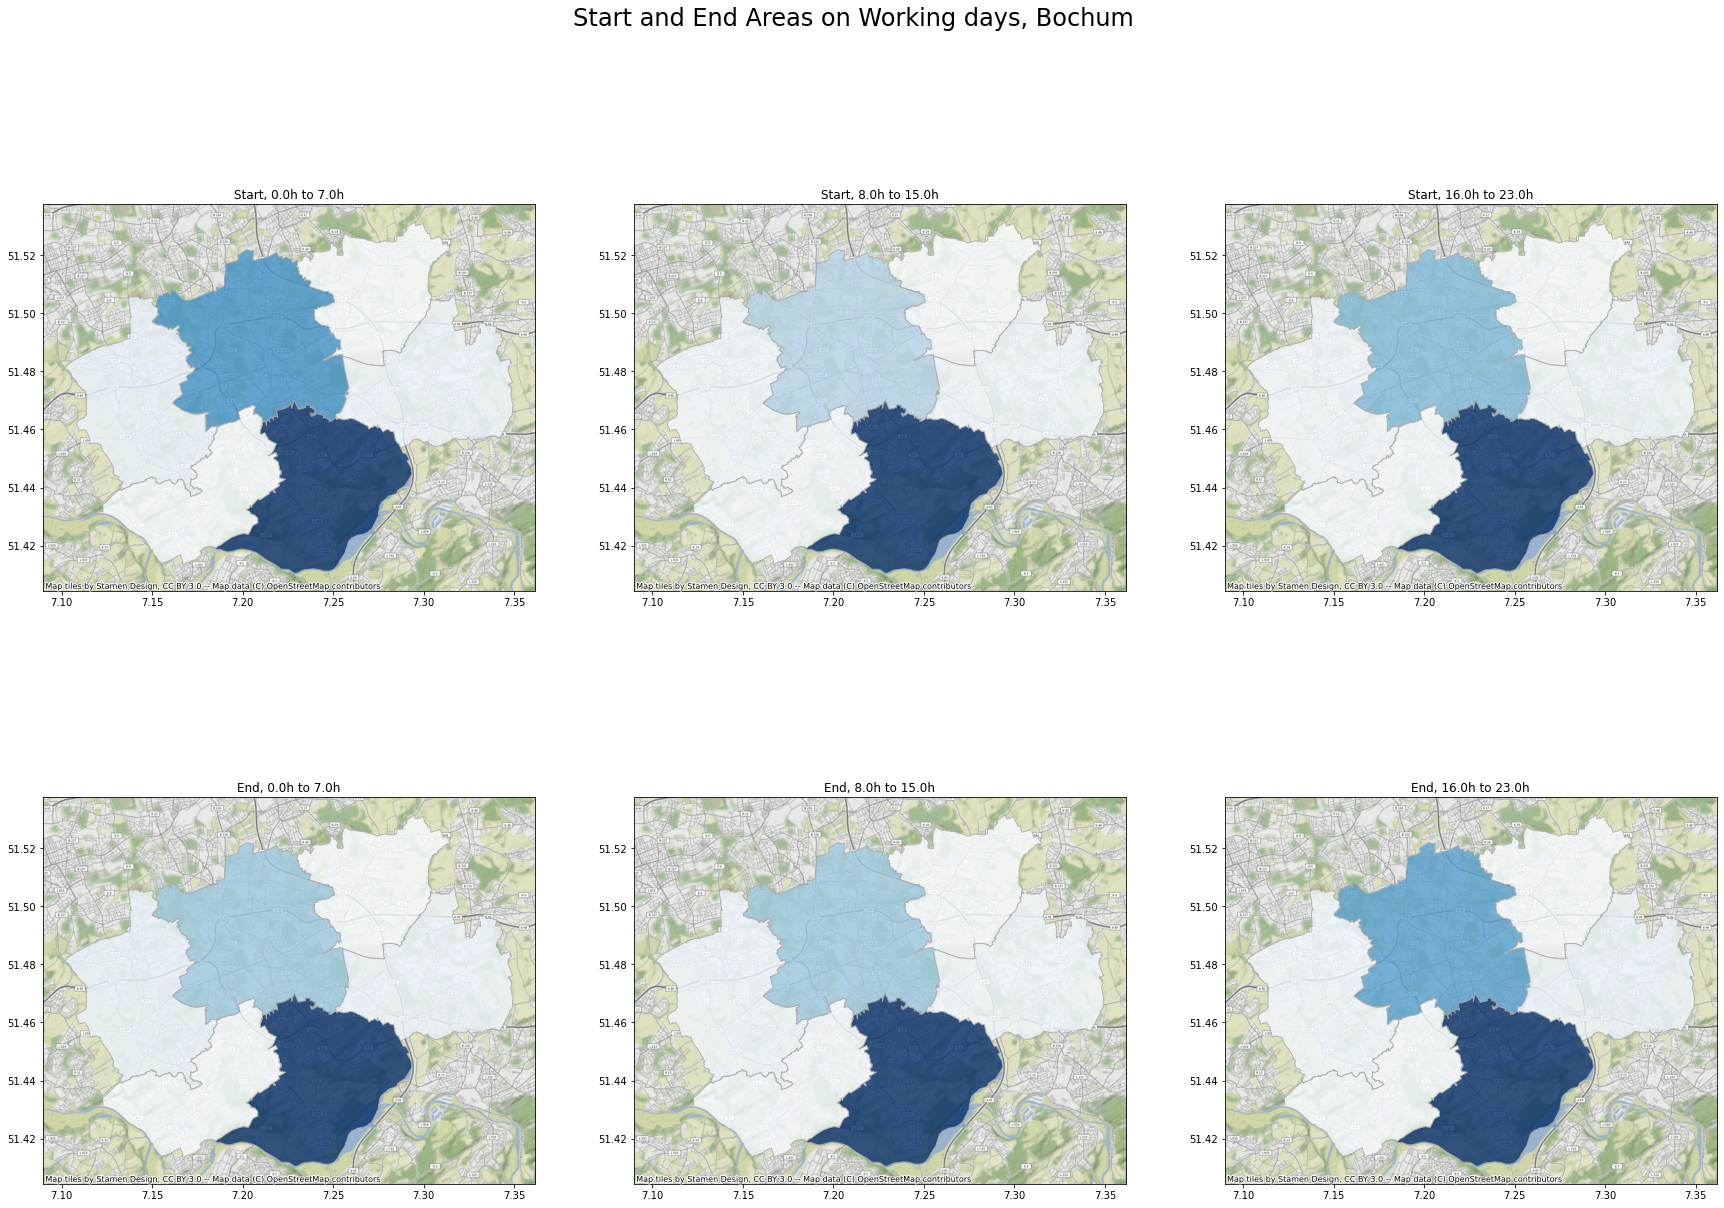

In [114]:
plot_sliced_days(df=df_b[df_b["free"]==False],polys=bochum_map,slices=3,titlecity="Bochum")

plt.savefig('./Exports/Rental-Patterns/geo_areas_bochum.png', bbox_inches='tight')


While the outcomes for Leipzig are quite detailed and allow for the conclusion that Nextbikes bikes are used to commute into the city in the morning and from the city in the evening, the area segments in the available Bochum map material seem to be too large to see such clear rental patterns. 

To solve this, we used KDE plotting from the Seaborn Library to produce a Heatmap-like Histogram that shows the same patterns without aggregating data to the respective areas.

In [115]:
def plot_locs_split(df,polys,splits,zoom,figsize,titlecity):
    slice_size = 24/splits
    fig, axes = plt.subplots(2,splits,figsize=figsize)
    fig.suptitle('Start and End Areas on Working days, '+titlecity, fontsize=24)
    
    polys.plot(ax=axes[0,0],zorder=1,alpha=0)

    xlim1,xlim2 = axes[0,0].get_xlim()
    ylim1,ylim2 = axes[0,0].get_ylim()
    
    xmid = xlim1+(xlim2-xlim1)/2
    ymid = ylim1+(ylim2-ylim1)/2
 
    
    #zoom feature
    xlim1 = xmid + (xlim1-xmid)/zoom
    xlim2 = xmid + (xlim2-xmid)/zoom
    ylim1 = ymid + (ylim1-ymid)/zoom
    ylim2 = ymid + (ylim2-ymid)/zoom


    i = 0
    while i < splits:

        min_time = i*slice_size
        max_time = (i+1)*slice_size - 1
        df_split = df[(df["Time"]>=min_time) & (df["Time"]<=max_time)] # filter for specific quarter of day

        u=0
        while u<2:
            polys.plot(ax=axes[u,i],zorder=1,alpha=0)
            # Plotting the KDE Plot as a heatmap


            lng = "orig_lng"
            lat = "orig_lat"
            if u ==1:
                lng = "dest_lng"
                lat = "dest_lat"

            sns.kdeplot(x=df_split[lng],
                        y=df_split[lat],
                        shade=True,
                        thresh=0.1,
                        cmap="hot",
                        ax=axes[u,i]) 

            ctx.add_basemap(ax=axes[u,i],crs=4326,alpha=0.8)
            polys.plot(ax=axes[u,i],zorder=1,facecolor="none", edgecolor="black")

            axes[u,i].set_ylim(ylim1,ylim2)
            axes[u,i].set_xlim(xlim1,xlim2)
            
            axes[u,i].set_axis_off()
            
            u = u + 1
        
        axes[0,i].set_title(str(int(min_time))+" to "+str(int(max_time))+" O'Clock")

        i = i + 1



In [116]:
plot_locs_split(df=df_b[df_b["free"]==False],polys=bochum_map,splits=3,zoom=1,figsize=(30,15),titlecity="Bochum") 

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_bochum.png', bbox_inches='tight')

TypeError: plot_locs_split() got an unexpected keyword argument 'titlecity'

In [ ]:
plot_locs_split(df=df_l[df_l["free"]==False],polys=leipzig_map,splits=3,zoom=1.3,figsize=(20,15),titlecity="Leipzig")

plt.savefig('./Exports/Rental-Patterns/geo_heatmap_leipzig.png', bbox_inches='tight')

____

# Clustering

In [74]:
df_clustering_b = df_b[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration",
                        "free"]]
df_clustering_b["trip_duration"] = df_clustering_b["trip_duration"].dt.total_seconds()/60
df_clustering_b_free = df_clustering_b[df_clustering_b["free"]==True]
df_clustering_b_work = df_clustering_b[df_clustering_b["free"]==False]

df_clustering_l = df_l[["Time_float",
                        "dest_lng",
                        "dest_lat",
                        "orig_lng",
                        "orig_lat",
                        "distance_traveled",
                        "trip_duration",
                        "free"]]
df_clustering_l["trip_duration"] = df_clustering_l["trip_duration"].dt.total_seconds()/60
df_clustering_l_free = df_clustering_l[df_clustering_l["free"]==True]
df_clustering_l_work = df_clustering_l[df_clustering_l["free"]==False]

<ipython-input-74-5b3c7f1f0fbe>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering_b["trip_duration"] = df_clustering_b["trip_duration"].dt.total_seconds()/60
<ipython-input-74-5b3c7f1f0fbe>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering_l["trip_duration"] = df_clustering_l["trip_duration"].dt.total_seconds()/60


In [175]:
def location_clustering_3d(df_clustering,n,lng,lat):
    
    df_clustering= df_clustering[["Time_float",lng,lat]]
    fig = plt.figure(figsize =(10,12))
    
    axis1 = fig.add_axes([0, 1, 0.2, 0.1]) # main axes
    axis2 = fig.add_axes([0, 1, 1, 1],projection='3d') # added axes
    #axis1 = fig.add_subplot()
    #axis2 = fig.add_subplot(projection='3d')
    
    df_clustering_n = min_max_scaling(df_clustering)

    ssd = []
    
    for i in range(2, 15):
        km = MiniBatchKMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)

    ssd=pd.DataFrame(ssd)
    ssd.columns = ["ssd"]

    axis1.plot(ssd)
    
    
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)

    
    
    _ = axis2.scatter(df_clustering["Time_float"],
                      df_clustering[lng],
                      df_clustering[lat],
                      s = 2,
                      c=labels,
                      alpha=1)

    axis2.invert_xaxis()
    
    plt.show()

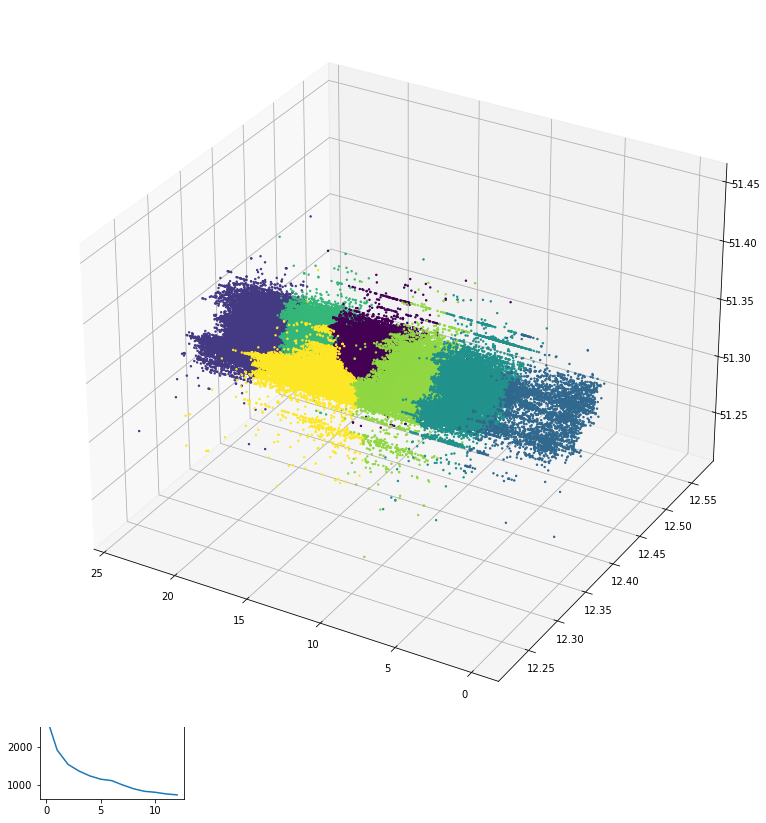

In [176]:
location_clustering_3d(df_clustering_l_work,7,"dest_lng","dest_lat")

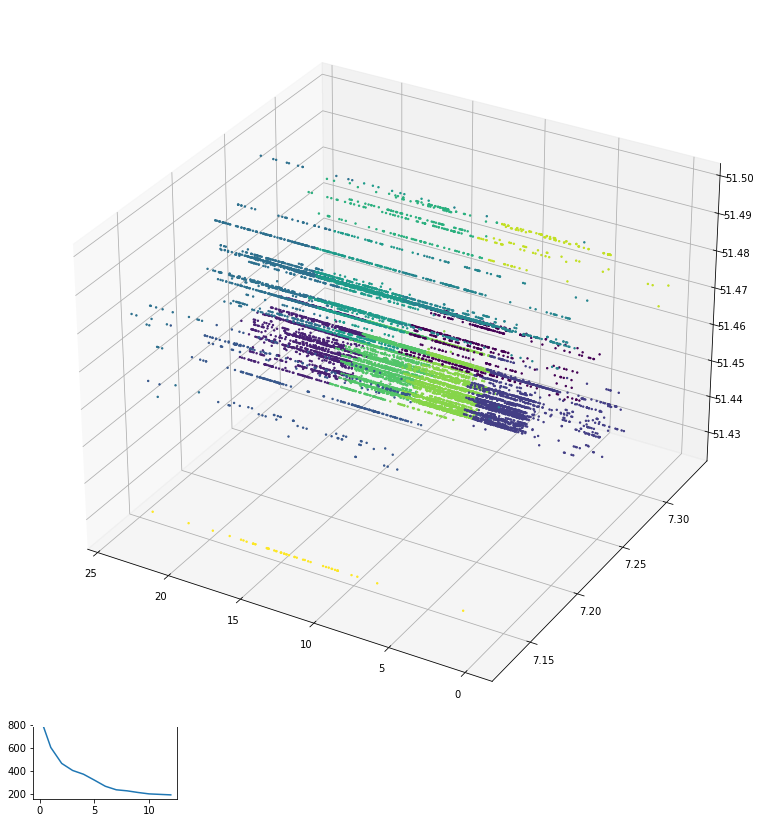

In [177]:
location_clustering_3d(df_clustering_b_work,12,"dest_lng","dest_lat")

# Trip Types

In [75]:
def clustering_2d(df,feature1,feature2,n):
    fig,ax=plt.subplots(1,2,figsize=(12,6))
    
    

    df_clustering = df[[feature1,feature2]]
    df_clustering_n = min_max_scaling(df_clustering)
    
    #L Curve
    ssd = []
    for i in range(2, 15):
        km = KMeans(n_clusters=i)
        km.fit_predict(df_clustering_n)
        ssd.append(km.inertia_)
    ax[1].plot(ssd)
        
    #Fit model 
    km = KMeans(n_clusters=n)
    labels = km.fit_predict(df_clustering_n)
    
    ax[0].scatter(x=df_clustering[feature1],y=df_clustering[feature2],c=labels)

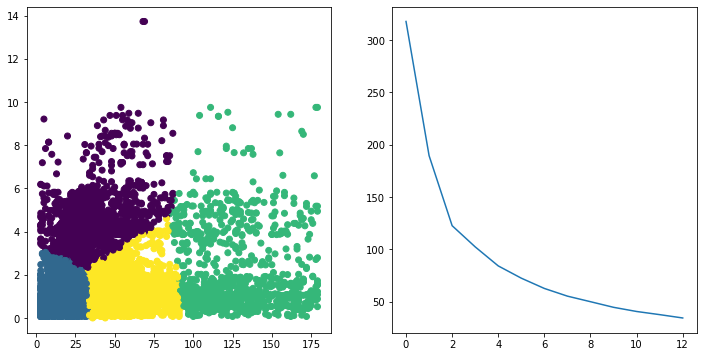

In [76]:
clustering_2d(df_clustering_b,"trip_duration","distance_traveled",4)

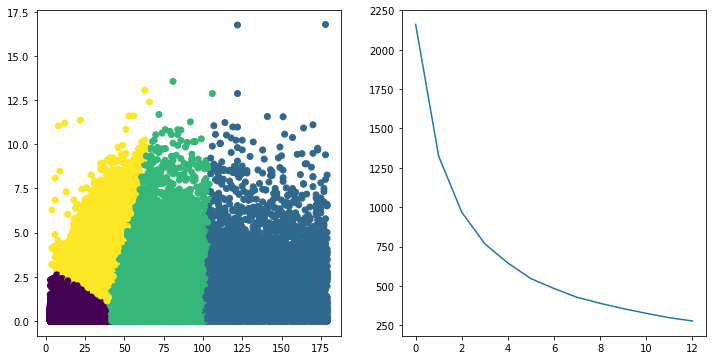

In [77]:
clustering_2d(df_clustering_l,"trip_duration","distance_traveled",4)

# Predictive Analytics

## Data Preparation
In this step, we need to add weather data to our existing features. While the DWD offers a lot of raw data, it is difficult to find daily weather data for our specific cities and would involve a lot of processing. We find that using data from meteostat makes this a lot easier as the processing is already done.

In [79]:
#Meteostat Data read-in
meteostat_l = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_l.index = dates
meteostat_l.drop(columns=["wpgt","wdir","date"],inplace=True)

meteostat_b = pd.read_csv("./weather-data/meteostat-bochum.csv") 
meteostat_b.index = dates
meteostat_b.drop(columns=["wpgt","wdir","date"],inplace=True)

### Comparison to DWD precipitation Data that we obtained through a difficult process
The DWD offers rasterised daily precipitation for raster points throughout Germany. However, this data is in an uncommon format and had to be processed with a customised Pyt

C:\Users\Leon\anaconda3\envs\aa\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


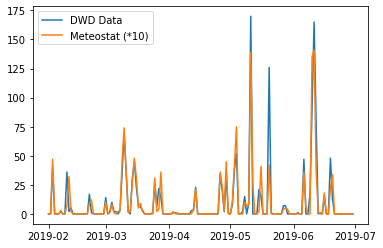

In [80]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

#Read in CDC Raster Data from single files and Filter for the calculated point
import os

path = './weather-data/dwd-raster/target/'
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates #indexing
rain_data.drop(columns=["ID"],inplace=True) 

#meteostat_leipzig.isnull().sum().sort_values(ascending=False)

plt.plot(rain_data.index,rain_data.VAL,label="DWD Data")
plt.plot(meteostat_l.index,meteostat_l.prcp*10, label="Meteostat (*10)")
plt.legend()

In [81]:
def df_predictive(df,meteostat):
    df["free_dummy"] = df["free"].astype(int)
    df = df.join(meteostat)
    df = df.drop(columns={"snow","free","daily_usage","weekday","daily_avg_length","weekly_trips","weekly_relative_trips","daily_revenue","daily_used_bikes"})
    return df

df_predictive_l = df_predictive(df_date_l,meteostat_l)
df_predictive_b = df_predictive(df_date_b,meteostat_b)
df_predictive_b

week  daily_trips  fleet_size  free_dummy  tavg  tmin  tmax  prcp  \
date                                                                           
2019-02-01    5           40         183           0   1.5  -2.0   6.5   3.0   
2019-02-02    5           27         183           1   0.7  -0.4   2.2   5.7   
2019-02-03    5           27         183           1   1.4  -1.7   4.6   0.0   
2019-02-04    6           47         183           0   2.1  -1.3   4.7   0.6   
2019-02-05    6           79         183           0   2.7   0.7   4.0   0.0   
...         ...          ...         ...         ...   ...   ...   ...   ...   
2019-06-26   26          255         306           0  25.3  18.1  30.4   0.0   
2019-06-27   26          242         311           0  19.4  14.1  25.6   0.0   
2019-06-28   26          255         313           0  18.5  11.1  25.9   0.0   
2019-06-29   26          124         307           1  23.9  11.9  33.7   0.0   
2019-06-30   26           92         308           1  24.9  17.0  31.4   0.0   

            wspd    pres  tsun  
date                            
2019-02-01    10   990.7   227  
2019-02-02     8   999.1     0  
2019-02-03     9  1019.6   174  
2019-02-04    15  1026.4   158  
2019-02-05    11  1026.9     0  
...          ...     ...   ...  
2019-06-26    12  1023.1   883  
2019-06-27    12  1027.2   788  
2019-06-28    10  1025.0   770  
2019-06-29     7  1018.8   930  
2019-06-30    13  1013.8   841  

[147 rows x 11 columns]

<AxesSubplot:>

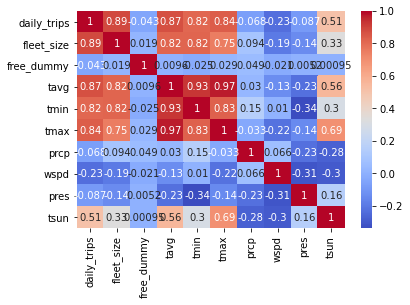

In [84]:
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm")


plt.savefig('./Exports/Predictive/leipzig_.png', bbox_inches='tight')

<AxesSubplot:>

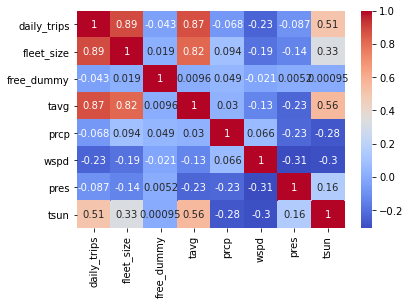

In [87]:
df_predictive_l = df_predictive_l.drop(columns=["tmin","tmax"])
sns.heatmap(df_predictive_l.corr(), annot=True,cmap ="coolwarm")

In [186]:
X = df_predictive_b.drop(columns=["daily_trips"])
Y = df_predictive_b[["daily_trips"]]

X_n =  min_max_scaling(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y,test_size = 0.3)

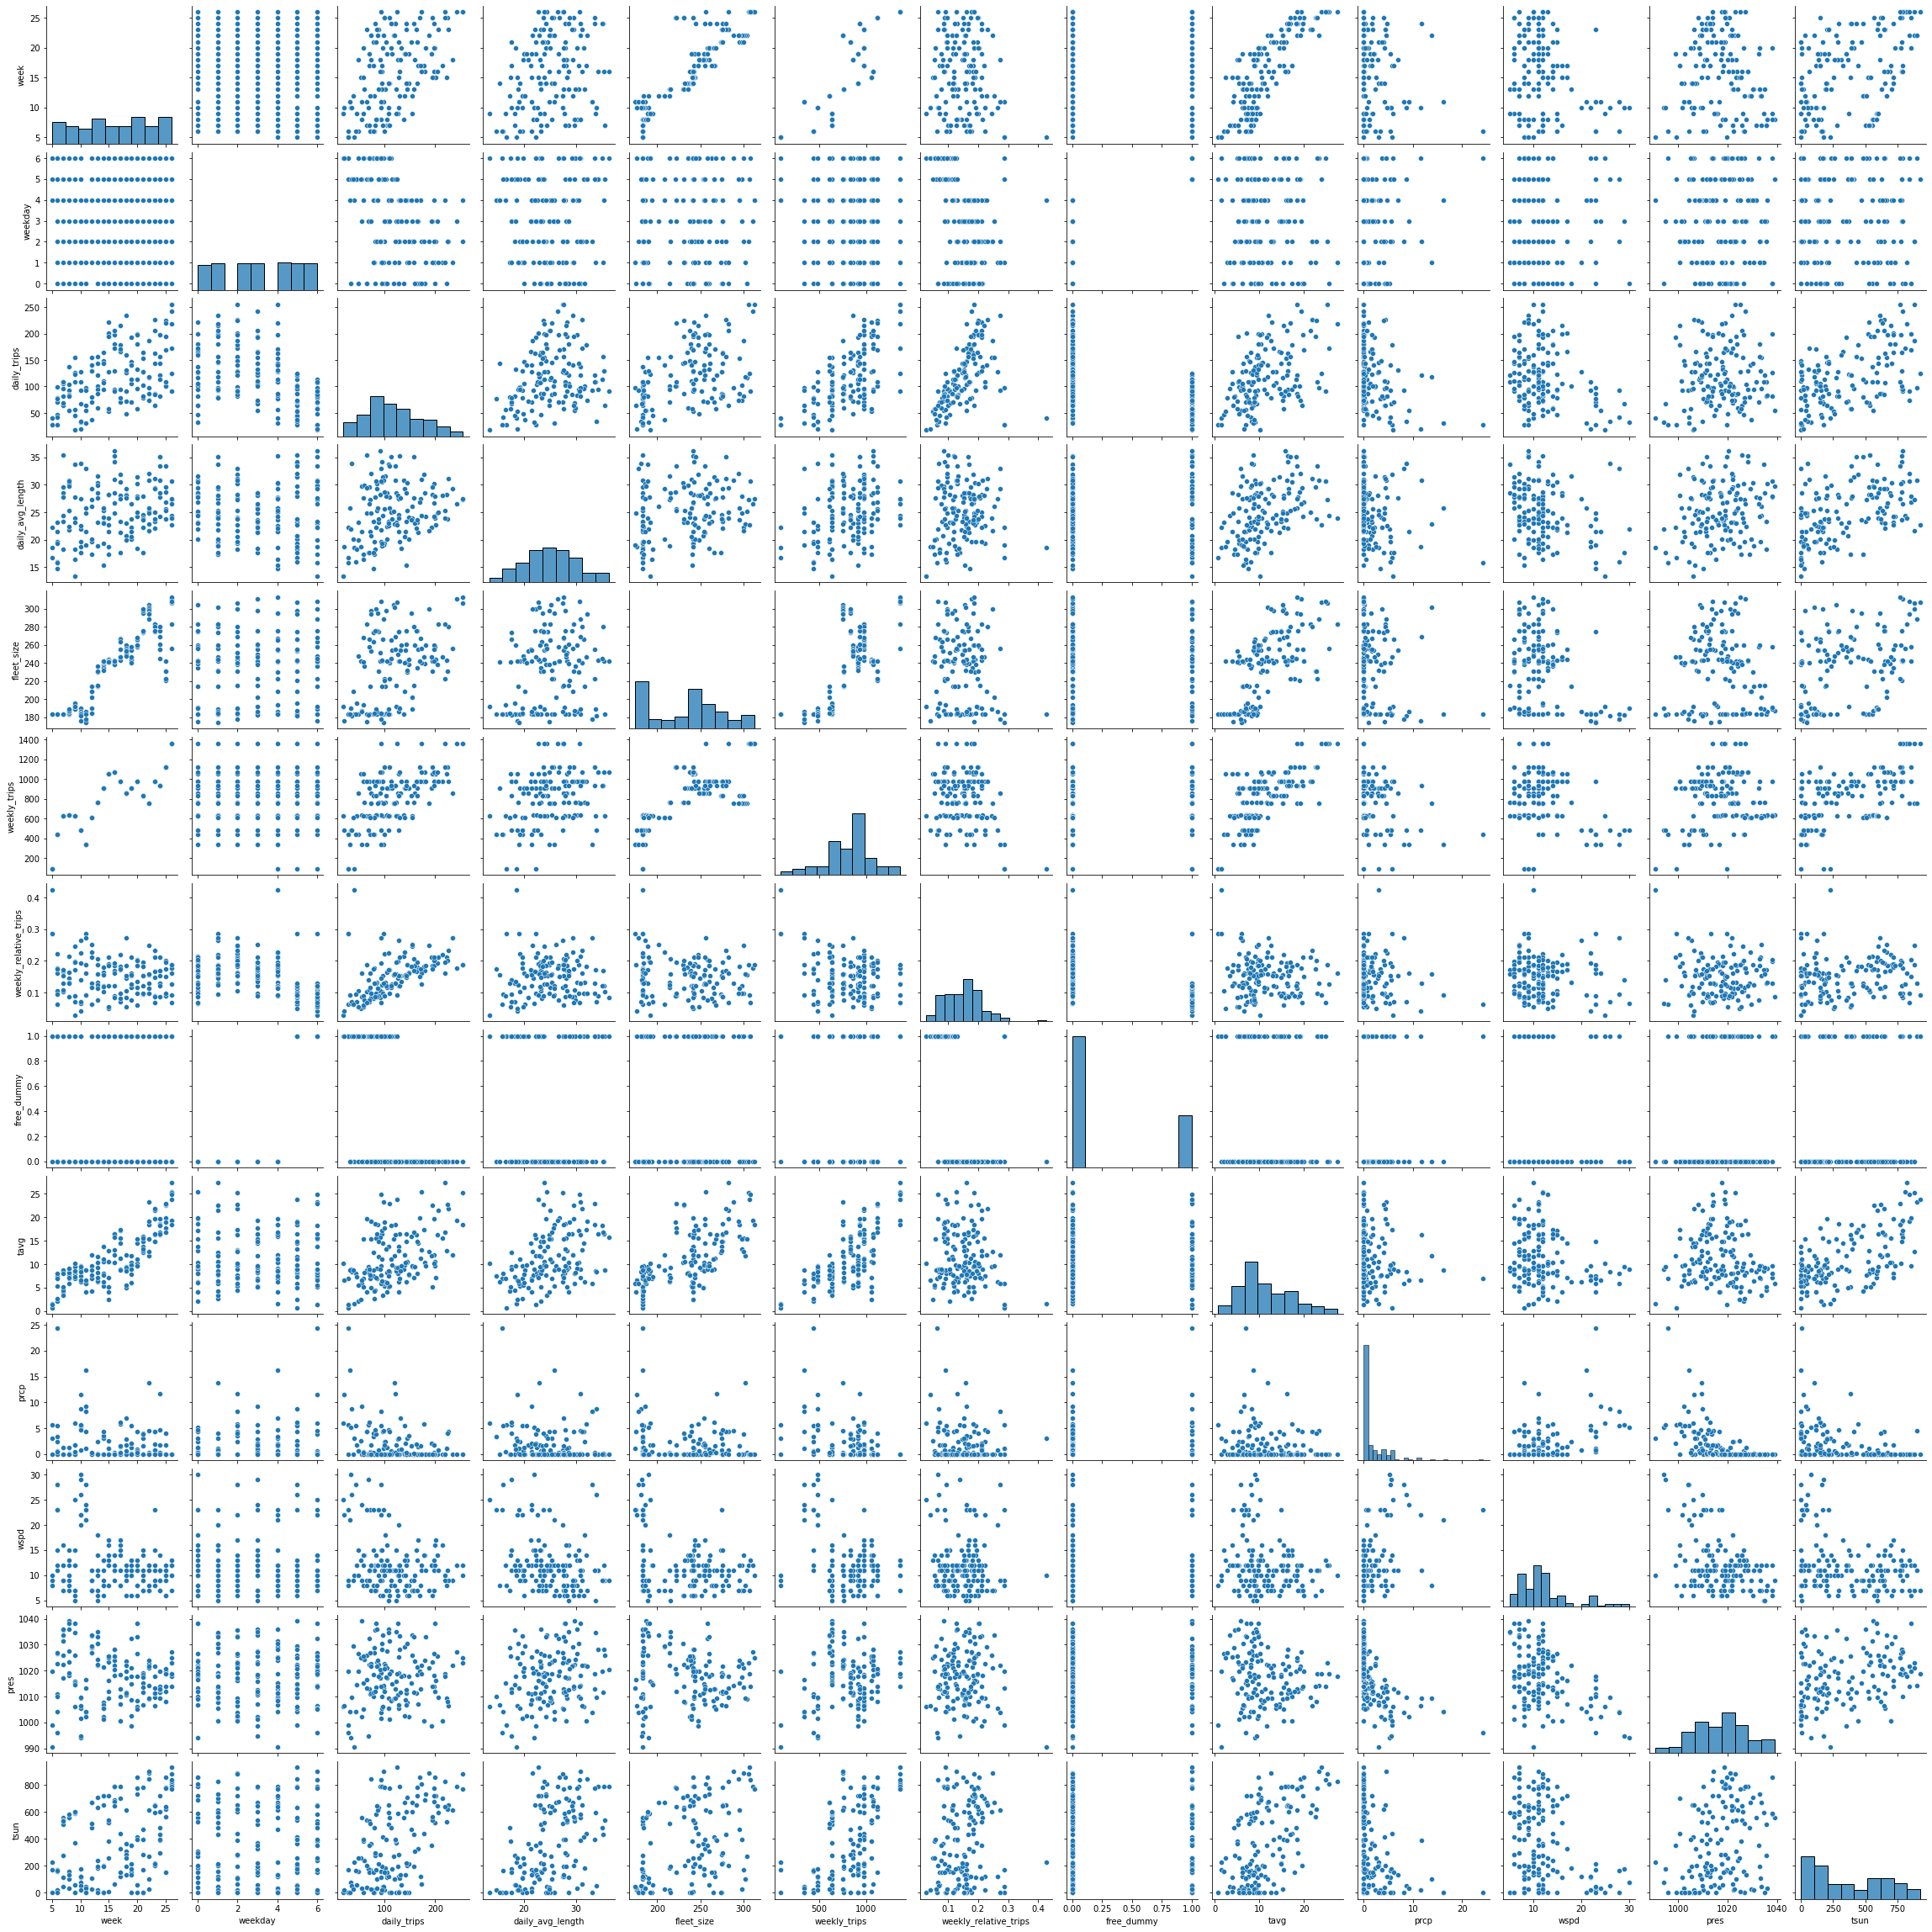

In [187]:
sns.pairplot(df_predictive_b)

best r2 is at: 5 : 0.7896321340916289


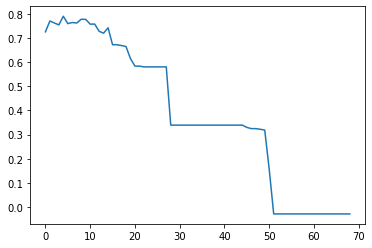

In [188]:
def tree_regression(Xtrain, Ytrain,Xtest, Ytest, min_leaves, xlabel, ylabel):
    Tree_reg = DecisionTreeRegressor(min_samples_leaf=min_leaves,criterion="mse")
    Tree_reg.fit(Xtrain, Ytrain)
    Y_pred = Tree_reg.predict(Xtest)
    
    r2= r2_score(Ytest, Y_pred)
    return r2

r2values=[]
i = 1
while i < 70:
    r2values.append(tree_regression(Xtrain = X_train, 
                                    Ytrain = Y_train,
                                    Xtest = X_test,
                                    Ytest =  Y_test, 
                                    min_leaves = i, 
                                    xlabel = "Avg Temperature", 
                                    ylabel = "Daily Trips"))
    i += 1
    
plt.plot(r2values)
r2max = np.argmax(r2values, axis=0) + 1
print("best r2 is at:", r2max,":", max(r2values))

R2: 0.7896321340916289


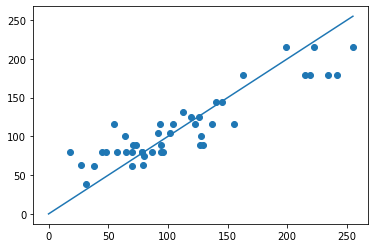

In [189]:
Tree_reg = DecisionTreeRegressor(min_samples_leaf=5,criterion="mse")
Tree_reg.fit(X_train, Y_train)
Y_pred = Tree_reg.predict(X_test)

test_set_r2 = r2_score(Y_test, Y_pred)
plt.scatter(Y_test, Y_pred)

max=Y_test.max()["daily_trips"]
x = np.linspace(0, max,max)
print("R2:", test_set_r2)
plt.plot(x,x)

R2: 0.8978921449425639


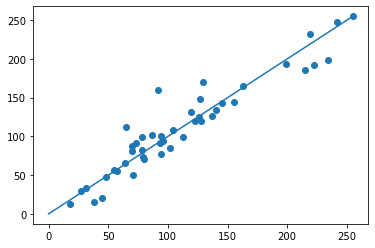

In [190]:
lin_reg_mod = LinearRegression(normalize=True)
lin_reg_mod.fit(X_train, Y_train)
pred = lin_reg_mod.predict(X_test)

test_set_r2 = r2_score(Y_test, pred)
plt.scatter(Y_test, pred)


max=Y_test.max()["daily_trips"]
x = np.linspace(0, max, max)
print("R2:", test_set_r2)
plt.plot(x,x)

In [191]:
pd.DataFrame(index=X_n.columns,data = lin_reg_mod.coef_.reshape(-1,1))


0
week                   -28.494110
weekday                  3.060665
daily_avg_length         2.988474
fleet_size              21.656344
weekly_trips           219.142801
weekly_relative_trips  208.748914
free_dummy             -28.697789
tavg                    24.140924
prcp                    45.168163
wspd                    23.902174
pres                    35.238120
tsun                     6.685048

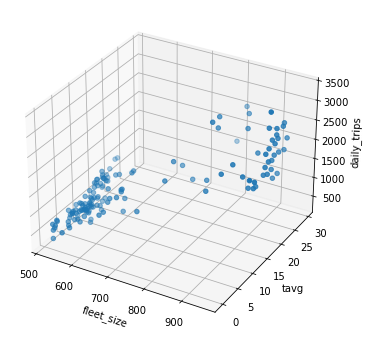

In [192]:
#%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(111, projection='3d')



z = df_predictive_l["daily_trips"]
y = df_predictive_l["tavg"]
x = df_predictive_l["fleet_size"]


ax.scatter(xs=x,ys=y,zs=z)
ax.set_xlabel('fleet_size')
ax.set_ylabel('tavg')
ax.set_zlabel('daily_trips')

plt.show()

_______________________________

# Backup

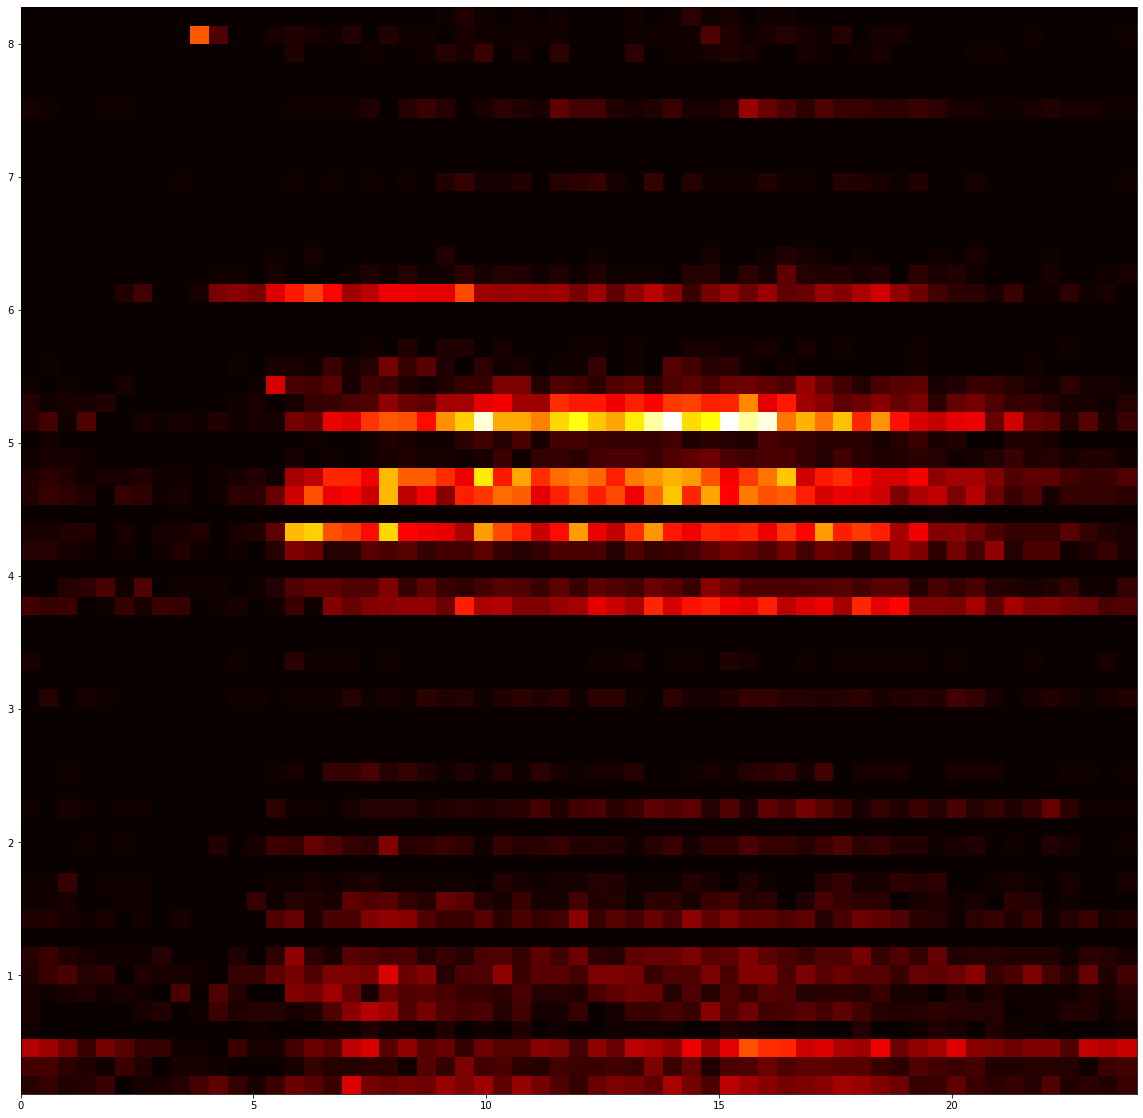

In [140]:
Fig,axis = plt.subplots(figsize=(20,20))

_ = axis.hist2d(df_b["Time_float"],
            df_b["start_distance_center"],
            bins=59,cmap="hot", 
            #range=[[0, 24], [0, 6]]
           )
#plt.scatter(df_l["Time"],df_l["start_distance_center"],alpha=0.002)

In [ ]:
cmap = cm.Blues

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

# Geographic Clustering for availability analysis

In [ ]:
locs = df[["orig_lat","orig_lng"]].rename(columns={"orig_lat": "lat","orig_lng":"lng"})
locs.append(df[["dest_lat","dest_lng"]].rename(columns={"dest_lat": "lat","dest_lng":"lng"}),ignore_index=True)
locs["gerade"] = locs.index % 2
locs

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans

ssd = []
for i in range(2, 60):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(locs)
    ssd.append(km.inertia_)
    
plt.plot(ssd)

In [ ]:
n = 40

km = MiniBatchKMeans(n_clusters=n)
km.fit_predict(locs)
clusters = pd.DataFrame(km.cluster_centers_)
clusters.columns = ['lat', 'lng']
clusters_gdf = gpd.GeoDataFrame(
    clusters.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(clusters["lng"], clusters["lat"]))

In [ ]:
locs_gdf = gpd.GeoDataFrame(
    locs.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(locs["lng"], locs["lat"]))
locs_gdf

In [ ]:
leipzig_map.head()

________________

## Availability Analysis
This function calculates what happened between rental times. It analyzes whether, between rentals, a bike has been available at a certain station or whether it has been moved to a different location. This can then be used for example to calculate the number of available bikes at a certain station at a single time. We use it to calculate our KPI of percentage of stations without available bikes. It can be used for further analysis in this topic as well.

In [ ]:
df

In [ ]:
df2 = df[:]

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', "revenue", "weekday", "Time", "timestamp_rounded","trip_duration"])

#df2 = df2.round({"orig_lat":round_factor, 'orig_lng':round_factor, 'dest_lat':round_factor, "dest_lng":round_factor})

#make sure it is sorted by b_number, then timestamp
df2 = df2.sort_values(by=['b_number','timestamp'])
#make sure the index is still +1 every time after sorting
df2.reset_index(inplace=True)
df2 = df2.rename(columns={"index": "original_index"})


df2

In [ ]:
df2 = df.copy()

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', "revenue", "weekday", "Time", "timestamp_rounded","trip_duration","week","max_distance_center"])

df3 = []
for number in df2.b_number.unique():
    dft = df2[df2["b_number"]==number]
    dft = dft.sort_values(by="timestamp")
    i = 0
    for index, row in dft.iterrows():
        i = i + 1
        if i > 1:
            status = "moved"
            if [row["orig_lat"],row["orig_lng"]] == last_dest:
                status = "stood"
                
            d = {
                "b_number": number,
                "from": last_timestamp,
                "to": row["timestamp"],
                "status": status
            }
            df3.append(d)
        last_timestamp = row["timestamp_end"]
        last_dest = [row["dest_lat"],row["dest_lng"]]

df3 = pd.DataFrame(df3)

df3["length"] = df3["to"] - df3["from"]
df3["length_int"] = df3["length"].dt.total_seconds() / (60* 60* 24)
df3["length_int"] = df3["length_int"].round()

df3_stood = df3[df3["status"]=="stood"].sort_values(by="length_int")

stood_length = df3_stood.groupby("length_int").agg(
    count = ("b_number","count")
)

In [ ]:
plt.plot(stood_length)

This step will take a while, as it clusters each entry to a specific cluster point, which takes a lot of computing power.

In [ ]:
df3 = []

bike_number = 0
bike_city = ""

for index in df2.index:
    if  df2.at[index,"b_number"] != bike_number:
        bike_number = df2.at[index,"b_number"]
        bike_city = df2.at[index,"city"]
    else:
        lat = df2.at[index,"orig_lat"]
        lng = df2.at[index,"orig_lng"]
        cluster_point = next_cluster(lng,lat,clusters)
        time_start = df2.at[index-1,"timestamp_end"]
        time_end = df2.at[index,"timestamp"]
        
        #status
        if index % 20000 == 0:
            print("reached row", index, "of", df2.index.max())
        
        action_type = "station"
        if lat == df2.at[index-1,"dest_lat"] and lng != df2.at[index-1,"dest_lng"]:
            action_type = "moved"
            
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_start,
            'action_type' : action_type+"_in",
            'cluster_point': cluster_point
            }
        df3.append(d)
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_end,
            'action_type' : action_type+"_out",
            'cluster_point': cluster_point
            }
        df3.append(d)

df3 = pd.DataFrame(df3)

In [ ]:
df3["cluster_point"] = df3["cluster_point"].astype(str)
df3

This algorithm takes goes over all records that relate to bikes standing at a certain station. For each change event, it calculates the effect on the capacity of a certain station.

In [ ]:
#filter df3 for all events related to bikes standing at a station (not being moved between rides)
df3 = df3[df3["action_type"].isin(["station_in","station_out"])]

#filter correctly for the algorithm to work properly
df3=df3.sort_values(by=['cluster_point','timestamp','action_type'])
df3.reset_index(inplace=True)
df3 = df3.rename(columns={"index": "original_index"})

df3["count"] = 0

station = ""
count = 0

for index in df3.index:
    action_type = df3.at[index,"action_type"]
    #if this is a different station, restart the calculation
    if  df3.at[index,"cluster_point"] != station:
        station = df3.at[index,"cluster_point"]
        count = 0
    if action_type == "station_in":
         count = count + 1
    elif action_type == "station_out":
        count = count - 1
    else:
        print("there was an error")
    
    df3.at[index,"count"] = count

In [ ]:
df3

This part produces a list of the minimum available bikes at a certain station. For example, if a station has had 2 bikes for the first ten minutes, then had 3 and in the end had only 1 bike left, this would count as 1 bike for the respective hour period. 
* If there was no change in available bikes, it takes the value for the most recent change event.
* If the number of available bikes changes to zero and no bikes ever get to the station again until the end of the data timeframe, it will not count as 0 bikes as the station might have been closed in the meantime (this should not count as "no bikes available)

In [ ]:
df3["timestamp_rounded"] = df3["timestamp"].dt.floor("H")
df3 = df3.sort_values(by=['cluster_point','timestamp'])

start_date = df3.timestamp_rounded.min()
end_date = df3.timestamp_rounded.max()
daterange = pd.date_range(start_date, end_date,freq='1H')

df4 = pd.DataFrame(index=daterange)

for cluster_point in df3.cluster_point.unique():
    dfl = df3[df3.cluster_point == cluster_point]
    dfl = dfl.groupby("timestamp_rounded").agg(
    min_count =("count","min"),
    last_value = ("count", lambda x: x.iloc[-1]))
    dfl = dfl.reindex(daterange, fill_value=None)
    dfl["last_value"] = dfl["last_value"].fillna(method='ffill')
    dfl["min_count"] = dfl.apply(
        lambda row: row['last_value']if np.isnan(row['min_count']) else row['min_count'],axis=1
    )
    for index, row in dfl[::-1].iterrows():
        if row["min_count"] == 0:
            row["min_count"] = None
        else:
            break
    df4[cluster_point] = dfl["min_count"]
    
df4 = df4.T

In [ ]:
#df4.to_excel("transposed.xlsx")
df5 = df4[df4 < 4].count()
df5
plt.plot(df5)

In [ ]:
plt.plot(fleet_size_b)

_______________________________

## Visualisation

In [ ]:
dates = df_by_date_merged.index
fleetsize = df_by_date_merged["fleet_size"]
usage = df_by_date_merged["usage"]
usedbikes = df_by_date_merged["used_bikes"]

Fig_1, ax_1 = plt.subplots()


color = 'tab:red'
ax_1.set_xlabel('Date')
ax_1.set_ylabel('Fleet Size', color=color)
ax_1.plot(dates, fleetsize, color=color)
ax_1.tick_params(axis='y', labelcolor=color)

ax_2 = ax_1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'

ax_2.set_ylabel("Used Bikes", color=color)
ax_2.plot(dates, usedbikes, color=color)
ax_2.tick_params(axis='y', labelcolor=color)

Fig_1.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Group by rounded start time

In [ ]:
df_by_time = df.groupby("Time").agg(
    mean_length=('trip_duration', lambda x: np.mean(x)),
    trip_count=('b_number', 'count'))

In [ ]:
fig, (ax1, ax1_b) = plt.subplots(nrows = 1, ncols = 2, figsize= (12,4))

x = df_by_time.index
seconds = df_by_time["mean_length"].dt.total_seconds()/60
amount = df_by_time["trip_count"]

color = 'tab:red'
ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Average trip length', color=color)
ax1.plot(x, seconds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total amount of trips', color=color)  # we already handled the x-label with ax1
ax2.plot(x, amount, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
df_distance_pattern = df.merge(date_info,left_on="date",right_index=True)
df_distance_pattern["holiday"] = df_distance_pattern["holiday"].astype(bool)
df_distance_pattern["free"] = df_distance_pattern["day_classifier"] == "weekend"
df_distance_pattern["free"] = df_distance_pattern["free"] | df_distance_pattern["holiday"]

df_distance_pattern_f = df_distance_pattern[df_distance_pattern["free"]==True]
df_distance_pattern_f = df_distance_pattern_f.groupby(["Time"]).agg(
                            start_distance_center = ("start_distance_center","mean"),
                            end_distance_center = ("end_distance_center","mean"))

df_distance_pattern_wd = df_distance_pattern[df_distance_pattern["free"]==False]
df_distance_pattern_wd = df_distance_pattern_wd.groupby(["Time"]).agg(
                            start_distance_center = ("start_distance_center","mean"),
                            end_distance_center = ("end_distance_center","mean"))


Fig_1, axes = plt.subplots(1, 2, figsize=(16, 6))

x = df_distance_pattern_f.index
y1 = df_distance_pattern_f["start_distance_center"]
y2 = df_distance_pattern_f["end_distance_center"]
axes[0].plot(x,y1,label="Start Distance")
axes[0].plot(x,y2,label="End Distance")
axes[0].set_title('Free Day')

x = df_distance_pattern_wd.index
y1 = df_distance_pattern_wd["start_distance_center"]
y2 = df_distance_pattern_wd["end_distance_center"]
axes[1].plot(x,y1,label="Start Distance")
axes[1].plot(x,y2,label="End Distance")
axes[1].set_title('Working Day')

for axis in axes:
    axis.set_ylim([0,3])
    axis.set_xlabel('Hour of the Day')
    axis.set_ylabel('Average Distance to City Centre')
    axis.legend()

    